In [7]:
from pathlib import Path
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
data_path = Path("S1_E1_A1.mat")

In [9]:
data = loadmat(data_path)

In [10]:
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


### Data visualisation
Visualisation of the raw EMG

In [11]:
# EMG and glove
emg = data['emg']             
glove = data['glove']       

# Select glove joints 3,6,8,11,14 (Python 0-indexed)
joint_idx = [2,5,7,10,13]
glove_selected = glove[:, joint_idx]

n_channels = emg.shape[1]
emg_cols = [f"EMG_{i+1}" for i in range(n_channels)]
joint_cols = [f"Joint_{i+1}" for i in joint_idx]

# Combine EMG and glove
df = pd.DataFrame(np.hstack([emg, glove_selected]), columns=emg_cols + joint_cols)



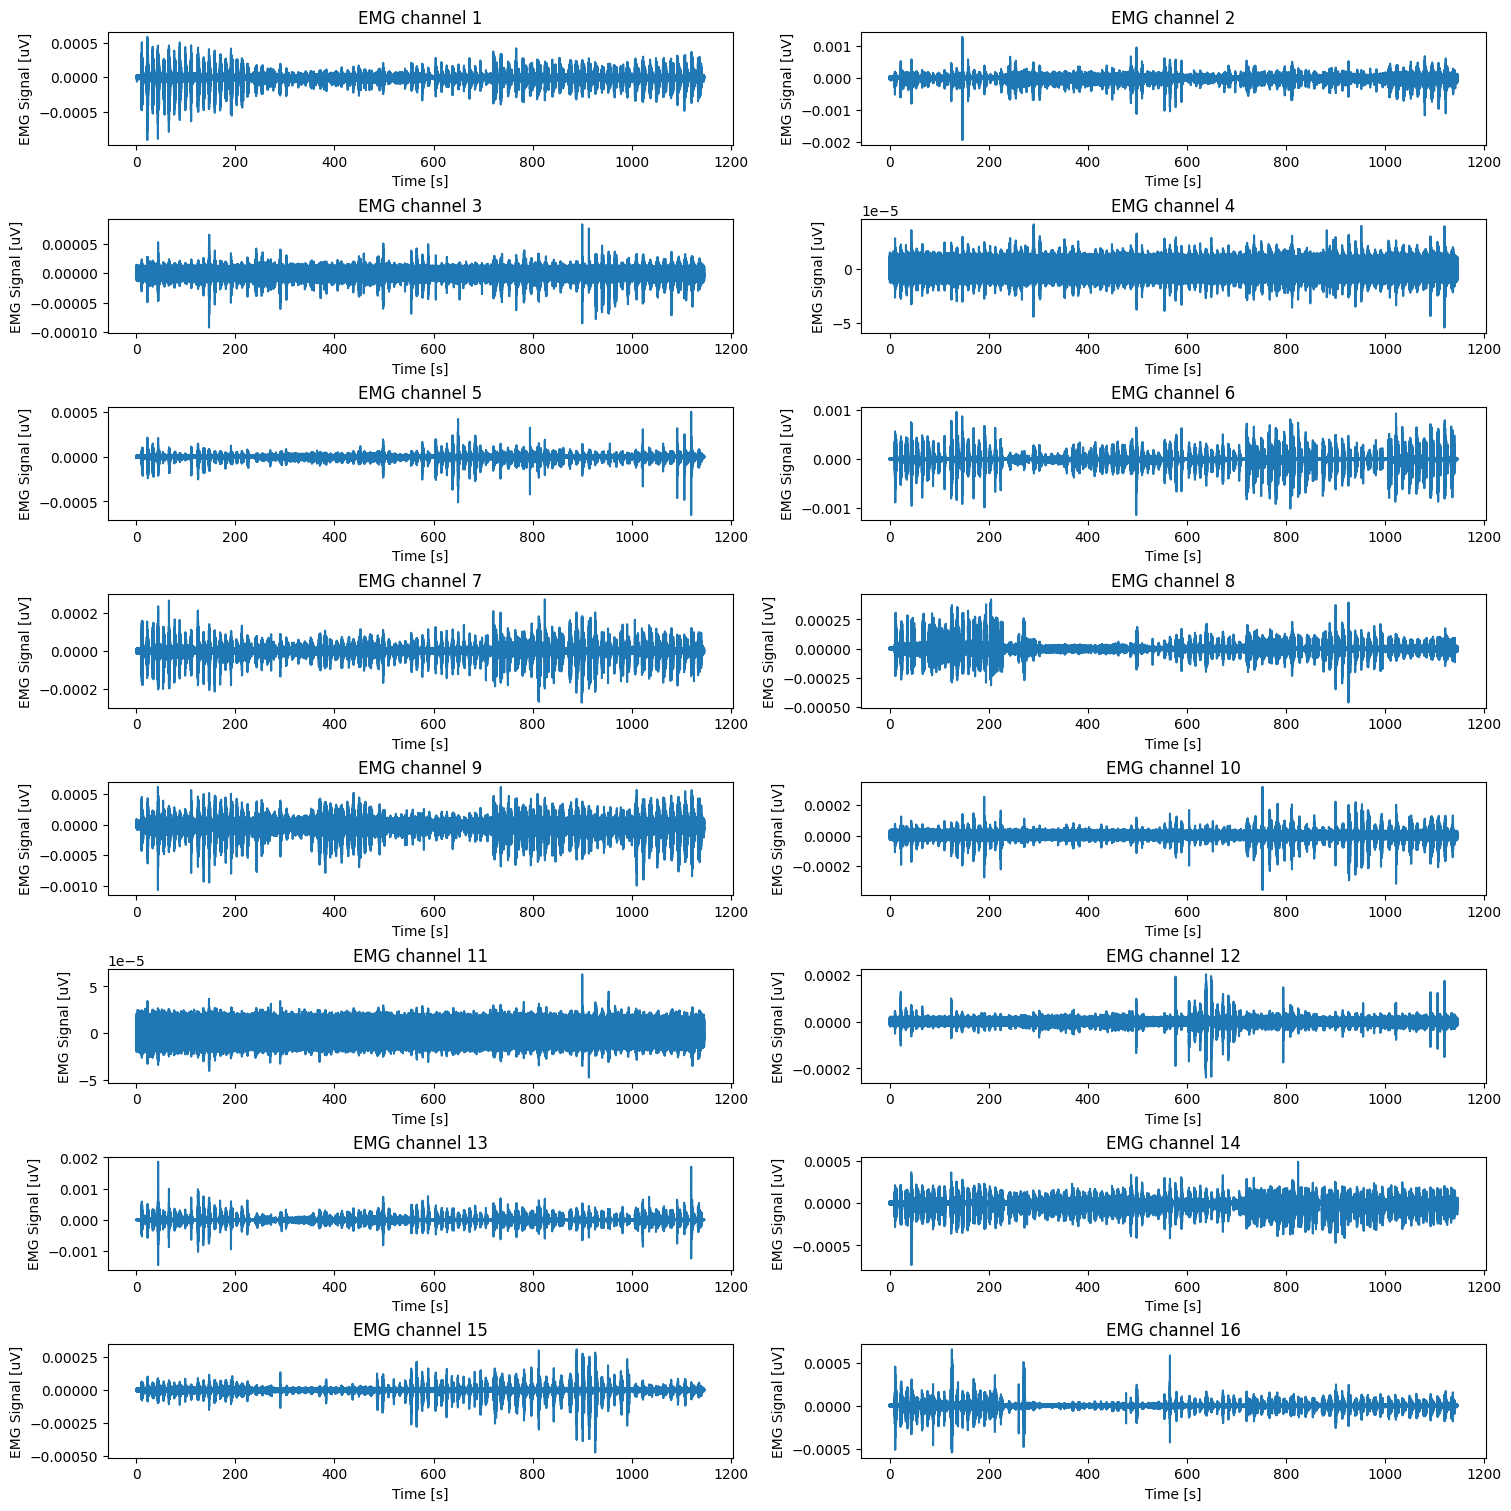

In [12]:
#In order to plot time based
# Sampling frequency
fs = 2000  # Hz
T = df.shape[0]  # total number of samples
time = np.arange(T) / fs

fig, ax = plt.subplots(8, 2, constrained_layout=True, figsize=(15, 15))

ax = ax.flatten() 

for i in range(16):
    ax[i].plot(time, emg[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"EMG channel {i+1}")

plt.show()


Visualise raw signal's raw spectral density using Welch

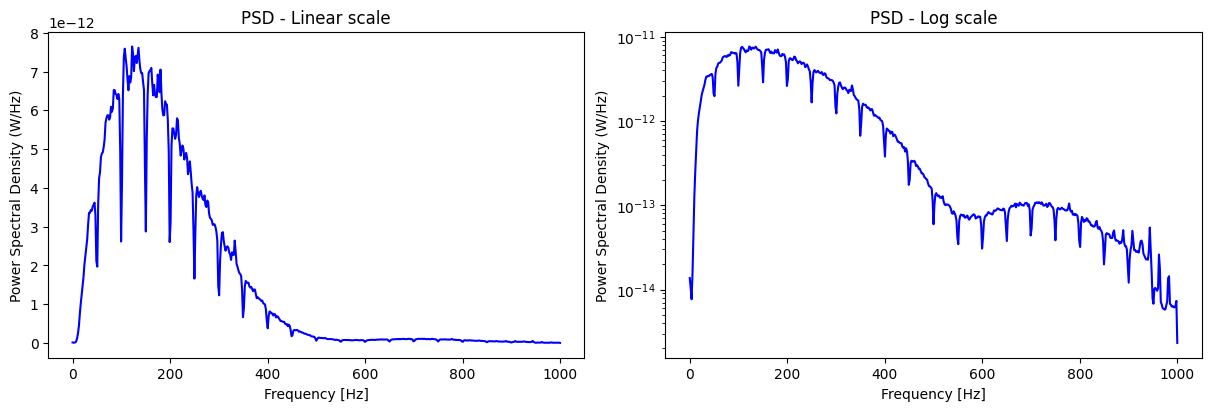

In [13]:
# emg : raw EMG data, shape (T, n_channels)
fs = 2000  # Hz

# Select channel to visualize
channel_idx = 5

# Compute PSD using Welch's method
freqs, Pxx = welch(emg[:, channel_idx], fs=fs, nperseg=1064)


# Plot PSD in linear and log scale
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

# Linear scale
ax[0].plot(freqs, Pxx, color='blue')
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("PSD - Linear scale")

# Log scale
ax[1].semilogy(freqs, Pxx, color='blue')
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("PSD - Log scale")

plt.show()


Based on the power spectral density, it seems that the signals that we imported have already been preporcessed, most notably powerline filtering at multiples of 50Hz as well as a steep drop off after 500 Hz which suggests that the signal has already been passed through a low pass filter.

### Visualsing Joint Angles
 joint angles of interest with colour separation for each of the activity repeats

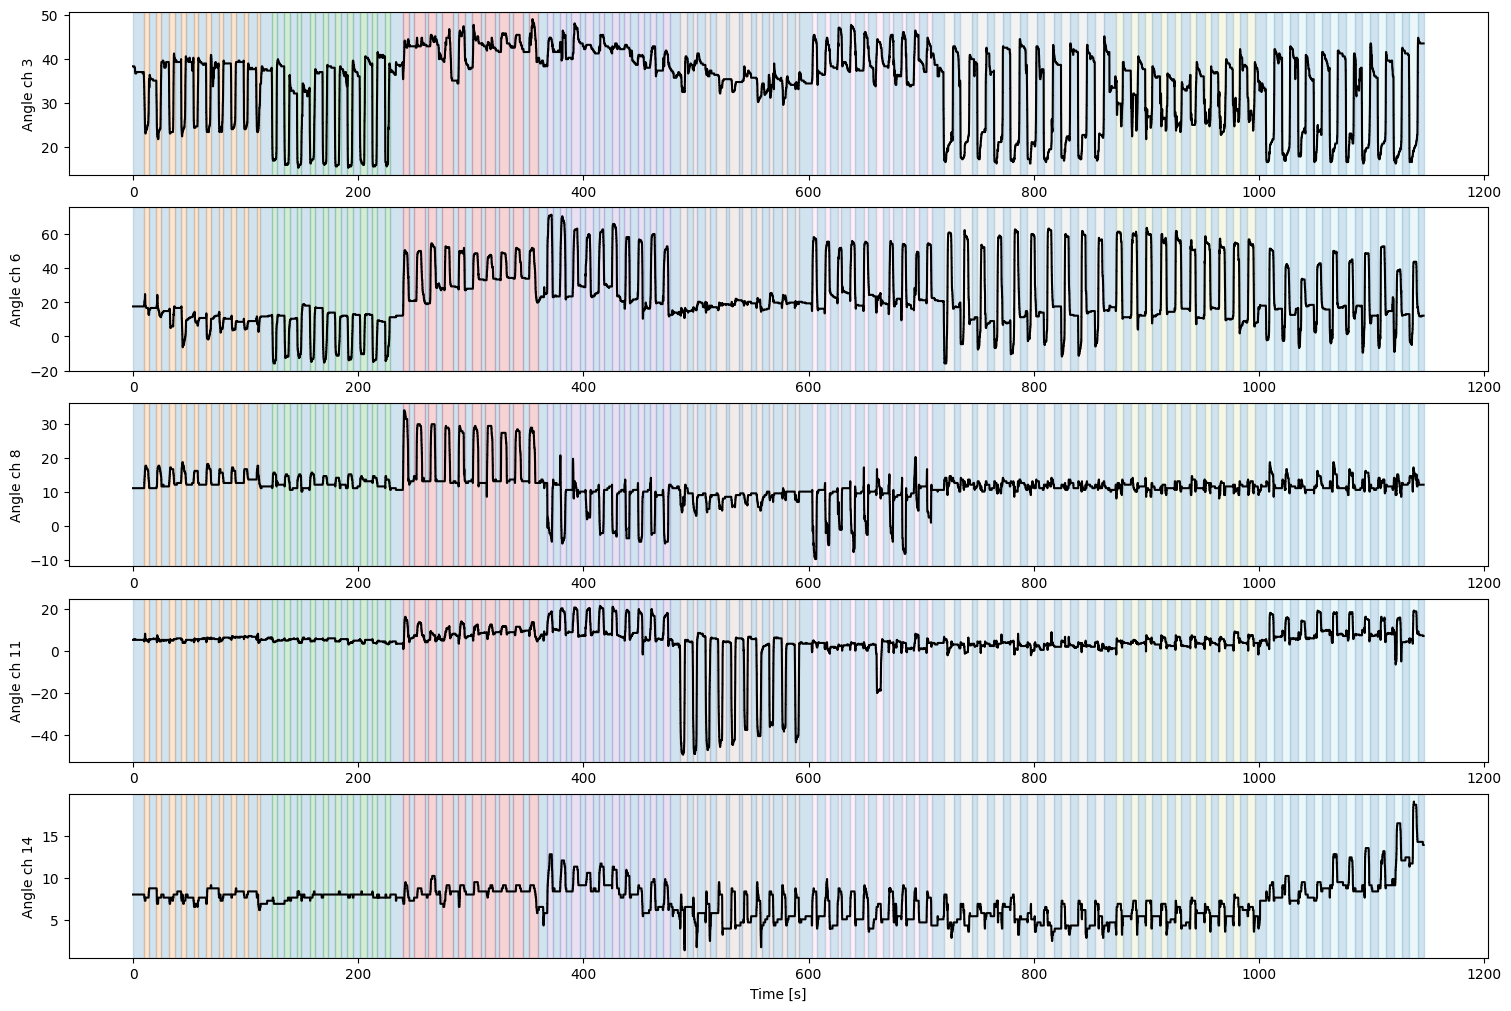

In [14]:

# Load glove angles
angle = data["glove"]
selected_channels = [3, 6, 8, 11, 14]  # indices of joint angle channels
angle = angle[:, selected_channels]
n_channels = angle.shape[1]

# Restimulus column
restimulus = data["restimulus"]  # same length as angle.shape[0]

# Sampling frequency
fs = 2000
time_steps = np.arange(0, angle.shape[0]/fs, 1/fs)

# Plot
fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 10))

# Define colors for shading
unique_stimuli = np.unique(restimulus)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_stimuli)))  # up to 20 different colors

for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, angle[:, channel_idx], color='black')
    ax[channel_idx].set_ylabel(f"Angle ch {selected_channels[channel_idx]}")
    
    # Shade regions by restimulus
    start_idx = 0
    current_stim = restimulus[0]
    for i in range(1, len(restimulus)):
        if restimulus[i] != current_stim:
            ax[channel_idx].axvspan(time_steps[start_idx], time_steps[i-1],
                                    color=colors[current_stim % len(colors)], alpha=0.2)
            start_idx = i
            current_stim = restimulus[i]
    # Shade last region
    ax[channel_idx].axvspan(time_steps[start_idx], time_steps[-1],
                            color=colors[current_stim % len(colors)], alpha=0.2)
    
    if channel_idx == n_channels - 1:
        ax[channel_idx].set_xlabel("Time [s]")

plt.show()


### Split data including rest
80% 10% 10% training, split, validation.
We used the rerepititon column in order to keep time indexs of the same repititions together during split

In [15]:

rerepetition = data['rerepetition'].flatten()  # shape: (T,)

unique_reps = np.unique(rerepetition)
unique_reps = unique_reps[unique_reps > 0]  # ignore rest

rng = np.random.default_rng(42)
shuffled_reps = rng.permutation(unique_reps)

n_train = int(0.8 * len(shuffled_reps))
n_val   = int(0.1 * len(shuffled_reps))
n_test  = len(shuffled_reps) - n_train - n_val

train_reps = shuffled_reps[:n_train]
val_reps   = shuffled_reps[n_train:n_train+n_val]
test_reps  = shuffled_reps[n_train+n_val:]


# Select indices for each split
train_idx = np.where(np.isin(rerepetition, train_reps))[0]
val_idx   = np.where(np.isin(rerepetition, val_reps))[0]
test_idx  = np.where(np.isin(rerepetition, test_reps))[0]

#Split EMG and joint angles
X_train = emg[train_idx, :]
X_val   = emg[val_idx, :]
X_test  = emg[test_idx, :]

y_train = angle[train_idx, :]
y_val   = angle[val_idx, :]
y_test  = angle[test_idx, :]

t_train = time_steps[train_idx]
t_val   = time_steps[val_idx]
t_test  = time_steps[test_idx]


print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)
print("Total time points after split:", len(train_idx) + len(val_idx) + len(test_idx))
print("Total original time points:", angle.shape[0])


Train shapes: (1849486, 16) (1849486, 5)
Validation shapes: (219693, 16) (219693, 5)
Test shapes: (213469, 16) (213469, 5)
Total time points after split: 2282648
Total original time points: 2292526


Visualising our training/ test/ validation split

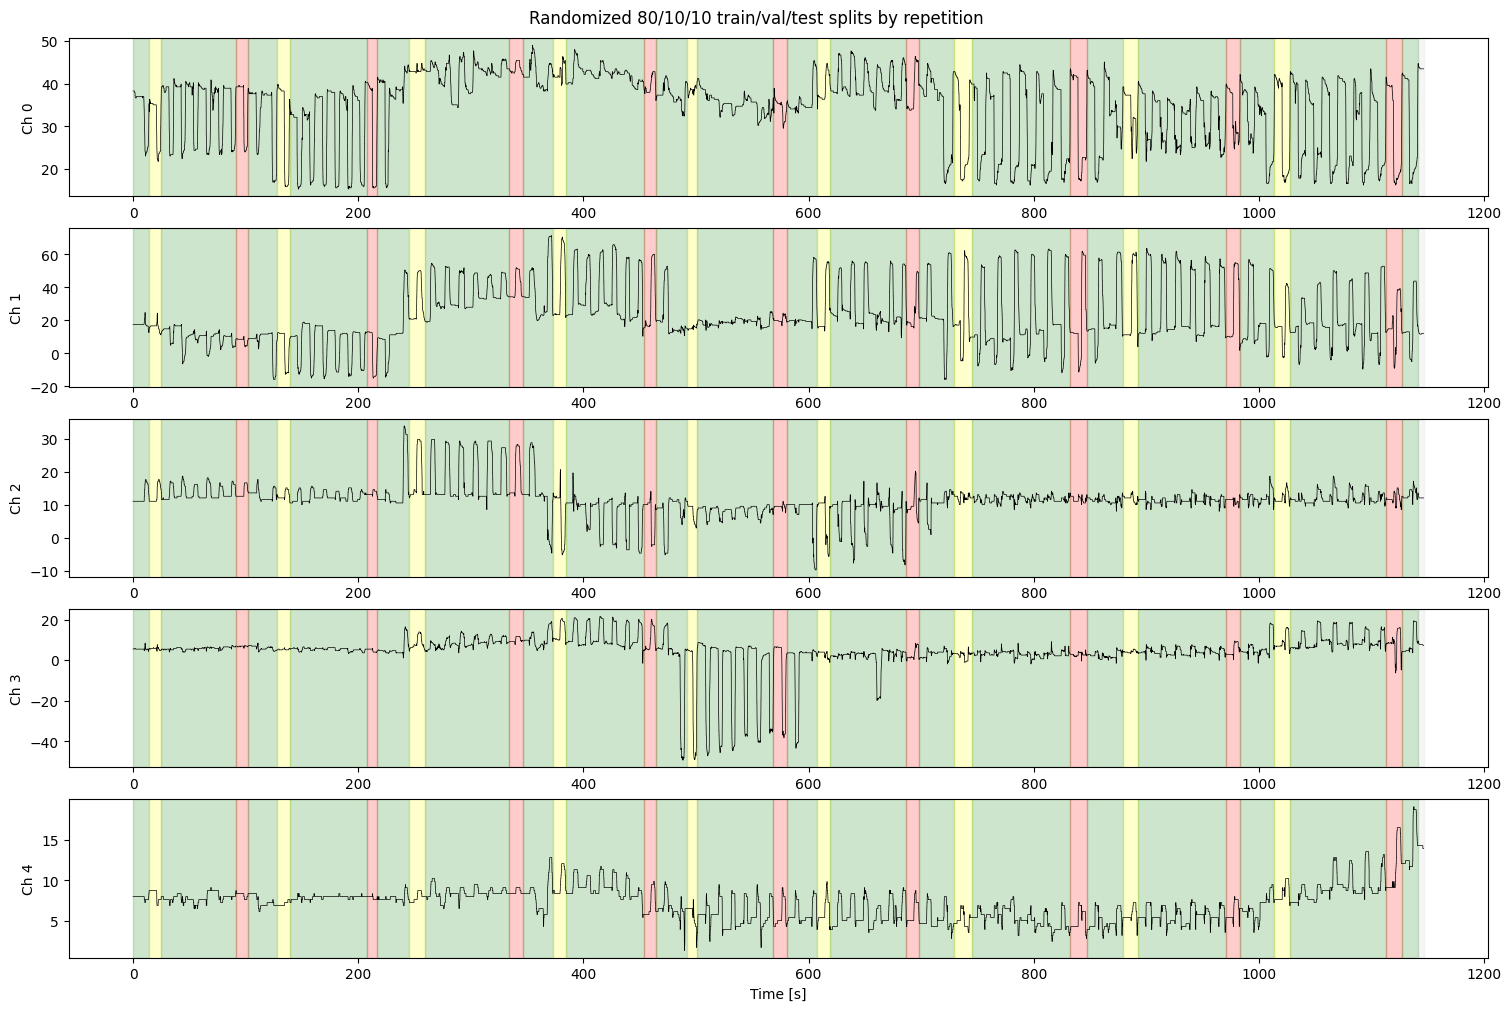

In [16]:
split_colors = np.zeros(len(rerepetition))
split_colors[train_idx] = 1
split_colors[val_idx]   = 2
split_colors[test_idx]  = 3

color_map = {0: 'lightgray', 1: 'green', 2: 'yellow', 3: 'red'}
n_channels = angle.shape[1]

fig, ax = plt.subplots(n_channels, 1, figsize=(15, 10), constrained_layout=True)

for ch in range(n_channels):
    ax[ch].plot(time_steps, angle[:, ch], color='black', lw=0.5)
    ax[ch].set_ylabel(f"Ch {ch}")

    # Shade background by split
    start_idx = 0
    current_split = split_colors[0]
    for i in range(1, len(split_colors)):
        if split_colors[i] != current_split:
            ax[ch].axvspan(time_steps[start_idx], time_steps[i-1],
                           color=color_map[current_split], alpha=0.2)
            start_idx = i
            current_split = split_colors[i]
    ax[ch].axvspan(time_steps[start_idx], time_steps[-1],
                   color=color_map[current_split], alpha=0.2)

    if ch == n_channels - 1:
        ax[ch].set_xlabel("Time [s]")

plt.suptitle("Randomized 80/10/10 train/val/test splits by repetition")
plt.show()


### Split Data without rest


In [17]:
rerepetition = data['rerepetition'].flatten()  # shape: (T,)
restimulus = data["restimulus"].flatten()  # shape (T,)

unique_reps = np.unique(rerepetition)
unique_reps = unique_reps[unique_reps > 0]  # ignore rest

rng = np.random.default_rng(42)  # reproducible
shuffled_reps = rng.permutation(unique_reps)

n_train = int(0.8 * len(shuffled_reps))
n_val   = int(0.1 * len(shuffled_reps))
n_test  = len(shuffled_reps) - n_train - n_val

train_reps = shuffled_reps[:n_train]
val_reps   = shuffled_reps[n_train:n_train+n_val]
test_reps  = shuffled_reps[n_train+n_val:]


# Select indices for each split (INCLUDE rests)
'''train_idx = np.where(np.isin(rerepetition, train_reps))[0]
val_idx   = np.where(np.isin(rerepetition, val_reps))[0]
test_idx  = np.where(np.isin(rerepetition, test_reps))[0]'''

# Select indices for each split (EXCLUDE rests)
train_idx = np.where(
    np.isin(rerepetition, train_reps) & (restimulus > 0)
)[0]

val_idx = np.where(
    np.isin(rerepetition, val_reps) & (restimulus > 0)
)[0]

test_idx = np.where(
    np.isin(rerepetition, test_reps) & (restimulus > 0)
)[0]

X_train = emg[train_idx, :]
X_val   = emg[val_idx, :]
X_test  = emg[test_idx, :]

y_train = angle[train_idx, :]
y_val   = angle[val_idx, :]
y_test  = angle[test_idx, :]

t_train = time_steps[train_idx]
t_val   = time_steps[val_idx]
t_test  = time_steps[test_idx]

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)
print("Total time points after split:", len(train_idx) + len(val_idx) + len(test_idx))
print("Total original time points:", angle.shape[0])

Train shapes: (886368, 16) (886368, 5)
Validation shapes: (111324, 16) (111324, 5)
Test shapes: (106659, 16) (106659, 5)
Total time points after split: 1104351
Total original time points: 2292526


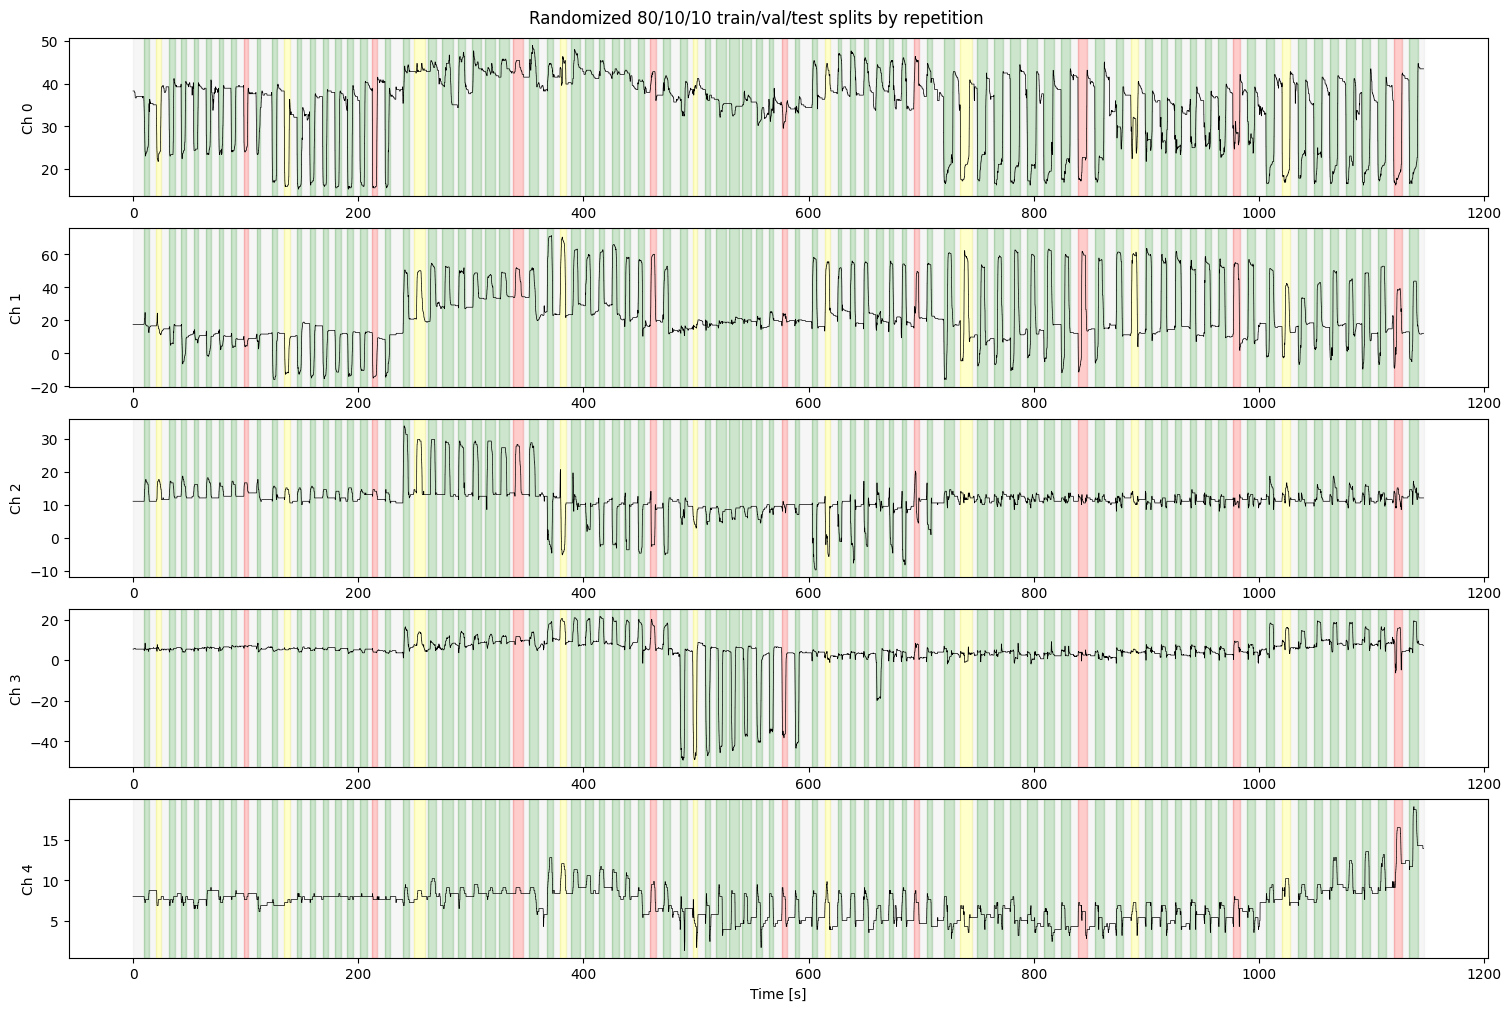

In [18]:
split_colors = np.zeros(len(rerepetition))
split_colors[train_idx] = 1
split_colors[val_idx]   = 2
split_colors[test_idx]  = 3

color_map = {0: 'lightgray', 1: 'green', 2: 'yellow', 3: 'red'}
n_channels = angle.shape[1]

fig, ax = plt.subplots(n_channels, 1, figsize=(15, 10), constrained_layout=True)

for ch in range(n_channels):
    ax[ch].plot(time_steps, angle[:, ch], color='black', lw=0.5)
    ax[ch].set_ylabel(f"Ch {ch}")

    # Shade background by split
    start_idx = 0
    current_split = split_colors[0]
    for i in range(1, len(split_colors)):
        if split_colors[i] != current_split:
            ax[ch].axvspan(time_steps[start_idx], time_steps[i-1],
                           color=color_map[current_split], alpha=0.2)
            start_idx = i
            current_split = split_colors[i]
    ax[ch].axvspan(time_steps[start_idx], time_steps[-1],
                   color=color_map[current_split], alpha=0.2)

    if ch == n_channels - 1:
        ax[ch].set_xlabel("Time [s]")

plt.suptitle("Randomized 80/10/10 train/val/test splits by repetition")
plt.show()


### Sliding Windows

We used a 128 ms window length to capture sufficient EMG temporal structure and a 50 ms step size to provide overlapping windows that improve temporal resolution while increasing the number of training samples.We also took the absolute value of the signal

In [19]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    EMG = np.abs(EMG)
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]

        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
        
    

    return EMG_windows, Labels_window




In [20]:
fs = 2000               
emg_window_length_sec = 0.2 # ms
incremental_window_length_sec = 0.05 #  ms step (≈60% overlap)

EMG_train_windows, Labels_train_windows = extract_time_windows_regression(
    X_train, y_train, fs, emg_window_length_sec, incremental_window_length_sec
)

EMG_val_windows, Labels_val_windows = extract_time_windows_regression(
    X_val, y_val, fs, emg_window_length_sec, incremental_window_length_sec
)

EMG_test_windows, Labels_test_windows = extract_time_windows_regression(
    X_test, y_test, fs, emg_window_length_sec, incremental_window_length_sec
)

print(f"EMG train windows shape: {EMG_train_windows.shape}, Train label windows shape: {Labels_train_windows.shape}")
print(f"EMG val windows shape:   {EMG_val_windows.shape}, Val label windows shape:   {Labels_val_windows.shape}")
print(f"EMG test windows shape:  {EMG_test_windows.shape}, Test label windows shape:  {Labels_test_windows.shape}")


EMG train windows shape: (8860, 400, 16), Train label windows shape: (8860, 400, 5)
EMG val windows shape:   (1110, 400, 16), Val label windows shape:   (1110, 400, 5)
EMG test windows shape:  (1063, 400, 16), Test label windows shape:  (1063, 400, 5)


## Extract the features, normalise, visualise

In [21]:
def compute_slope_feature(EMG_windows, fs):
    """
    EMG_windows: (n_windows, win_len, n_channels)
    fs: sampling frequency
    """
    n_windows, win_len, n_channels = EMG_windows.shape

    # Time vector (in seconds)
    t = np.arange(win_len) / fs
    t = t - np.mean(t)  # zero-mean for numerical stability
    denom = np.sum(t**2)

    # Allocate
    slopes = np.zeros((n_windows, n_channels))

    for w in range(n_windows):
        # Linear regression slope for each channel
        slopes[w, :] = np.sum(t[:, None] * EMG_windows[w], axis=0) / denom

    return slopes
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    Extract mean and std for each window
    """
    # along axis 1 (time axis)
    EMG_mean = np.mean(EMG_windows, axis=1)   # mean per window per channel
    EMG_std = np.std(EMG_windows, axis=1)     # std per window per channel
    EMG_slope = compute_slope_feature(EMG_windows, fs)
    Labels_mean = np.mean(Labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean,EMG_std, EMG_slope), axis=1)
    return EMG_extracted_features, Labels_mean

In [22]:

# Extract features for train, validation, and test sets

EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows, Labels_train_windows)
EMG_val_extracted_features, Labels_val_mean     = extract_features(EMG_val_windows, Labels_val_windows)
EMG_test_extracted_features, Labels_test_mean   = extract_features(EMG_test_windows, Labels_test_windows)


print("EMG train extracted features shape: {}, Finger labels means shape: {}".format(
    EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG val extracted features shape: {}, Finger labels means  shape: {}".format(
    EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Finger labels mean shape: {}".format(
    EMG_test_extracted_features.shape, Labels_test_mean.shape))


EMG train extracted features shape: (8860, 48), Finger labels means shape: (8860, 5)
EMG val extracted features shape: (1110, 48), Finger labels means  shape: (1110, 5)
EMG test extracted features shape: (1063, 48), Finger labels mean shape: (1063, 5)


In [23]:
#normalize the EMG features 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
EMG_train_extracted_features = scaler.fit_transform(EMG_train_extracted_features)
EMG_val_extracted_features = scaler.transform(EMG_val_extracted_features)
EMG_test_extracted_features = scaler.transform(EMG_test_extracted_features)

### Correlation Matrix of EMG Features

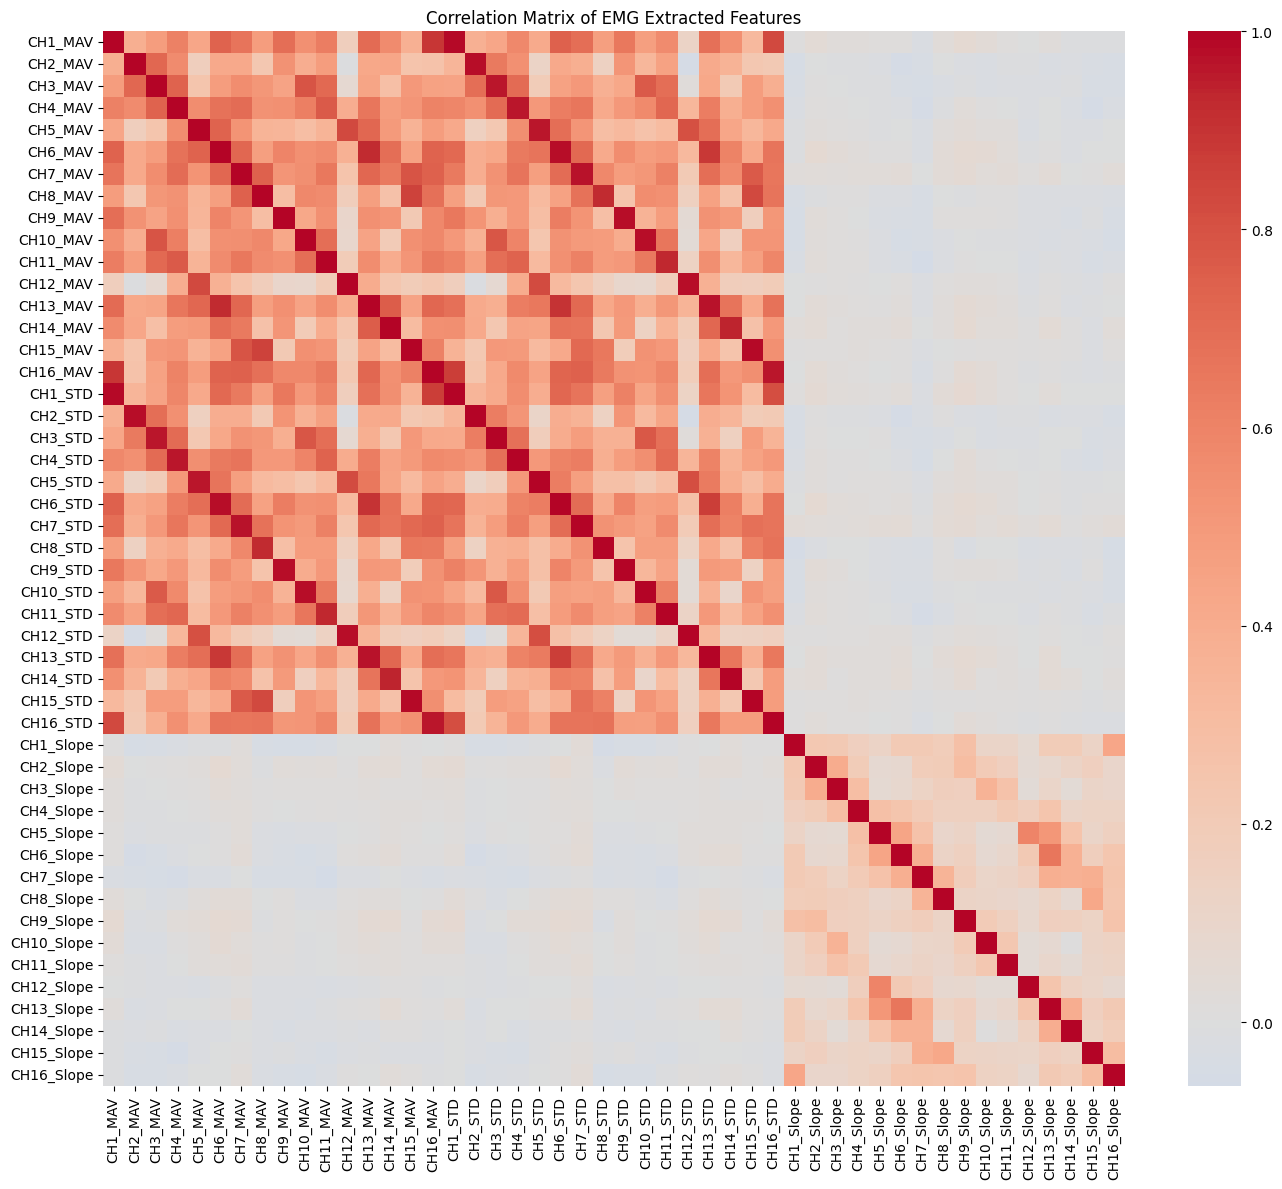

In [25]:
import seaborn as sns
# Correlation analysis between EMG features

corr_matrix = pd.DataFrame(EMG_train_extracted_features).corr()

EMG_Channel = [f"CH{i}" for i in range(1, 17)]
metrics = ['MAV', 'STD', 'Slope']
#correlation matrix labels
feature_names = [
    f"{ch}_{m}"
    for m in metrics
    for ch in EMG_Channel
]

corr_matrix = pd.DataFrame(
    EMG_train_extracted_features,
    columns=feature_names
).corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Matrix of EMG Extracted Features")
plt.tight_layout()
plt.show()

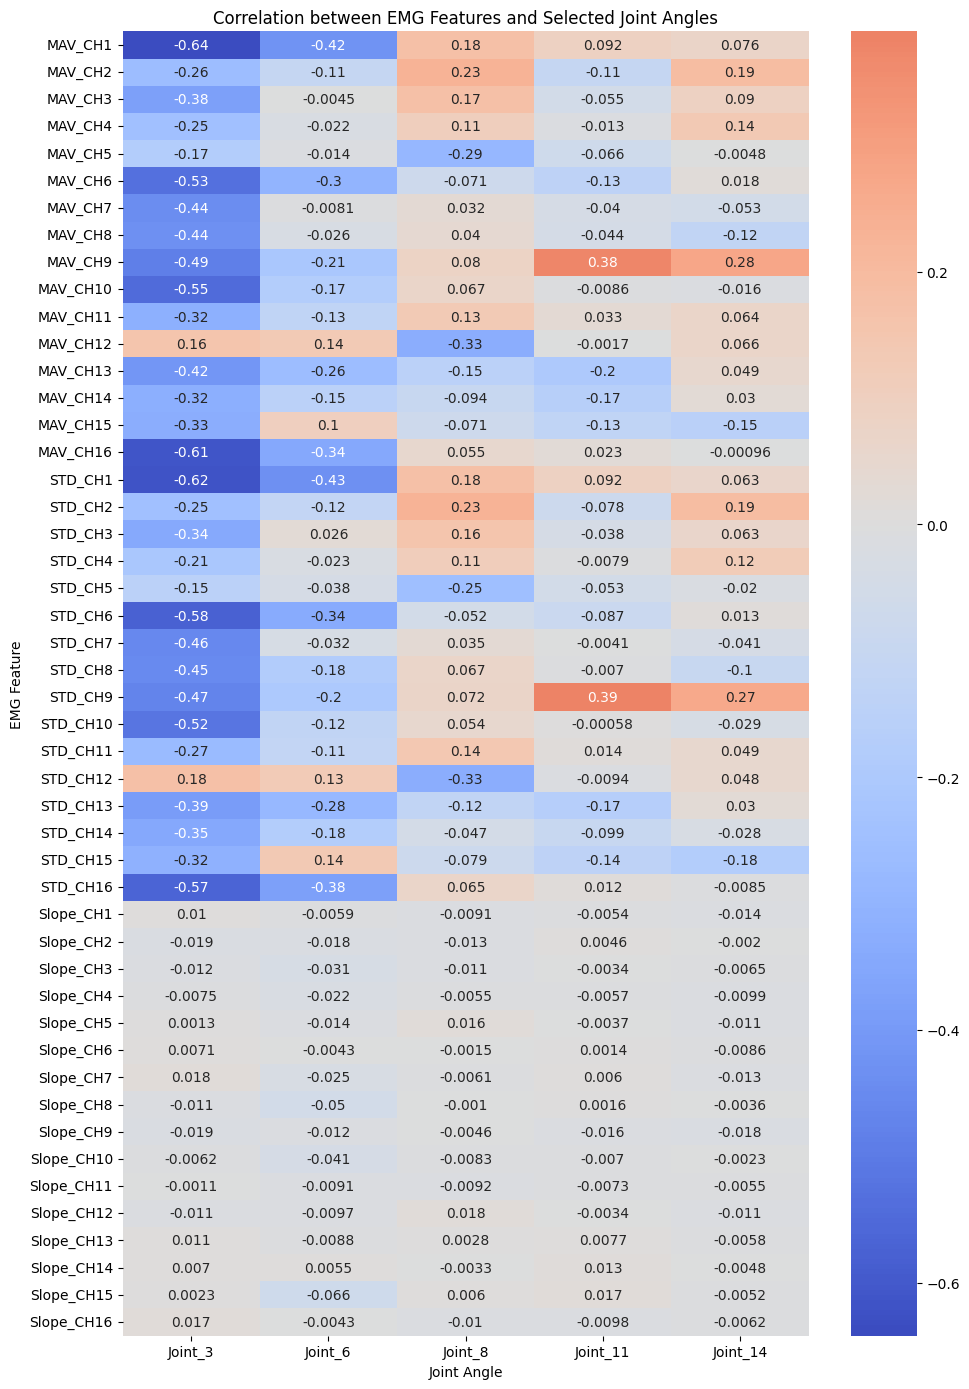

In [26]:
# EMG feature labels (MAV/STD/Slope)
n_channels = 16
features = ['MAV', 'STD', 'Slope']

emg_feature_names = [
    f'{feat}_CH{ch+1}'
    for feat in features
    for ch in range(n_channels)
]

emg_df = pd.DataFrame(
    EMG_train_extracted_features,
    columns=emg_feature_names
)

# Joint angle labels
joint_ids = [3, 6, 8, 11, 14]
labels_df = pd.DataFrame(
    Labels_train_mean,
    columns=[f'Joint_{j}' for j in joint_ids]
)

# Initialize correlation matrix
corr_matrix = pd.DataFrame(
    index=emg_df.columns,
    columns=labels_df.columns
)

# Compute correlations
for emg_col in emg_df.columns:
    for label_col in labels_df.columns:
        corr_matrix.loc[emg_col, label_col] = emg_df[emg_col].corr(labels_df[label_col])

corr_matrix = corr_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between EMG Features and Selected Joint Angles")
plt.xlabel("Joint Angle")
plt.ylabel("EMG Feature")
plt.tight_layout()
plt.show()


### Regression with GLM 
We will perform a Linear Regression on the Kinematics of the Gloves with predictors of the EMG. 



In [27]:
print(EMG_train_extracted_features.shape)
print(Labels_train_mean.shape)


(8860, 48)
(8860, 5)


In [28]:
from sklearn.linear_model import LinearRegression

#Excluding SLOPE since it is not correlated to joint angle
EMG_train_extracted_features = EMG_train_extracted_features[:, :32]
EMG_test_extracted_features = EMG_test_extracted_features[:, :32]
EMG_val_extracted_features = EMG_val_extracted_features[:, :32]
#Fit and predict using the linear regressor
#EMG_train_extracted_features = array of shape (num_windows, num_features) with std,mean, max for each window for each EMG channel
#Labels_train_mean = array of shape (num_windows, 2) with the mean joint angles for each window
linear_regressor = LinearRegression() 
linear_regressor.fit(EMG_train_extracted_features, Labels_train_mean)
y_pred_linear = linear_regressor.predict(EMG_val_extracted_features)



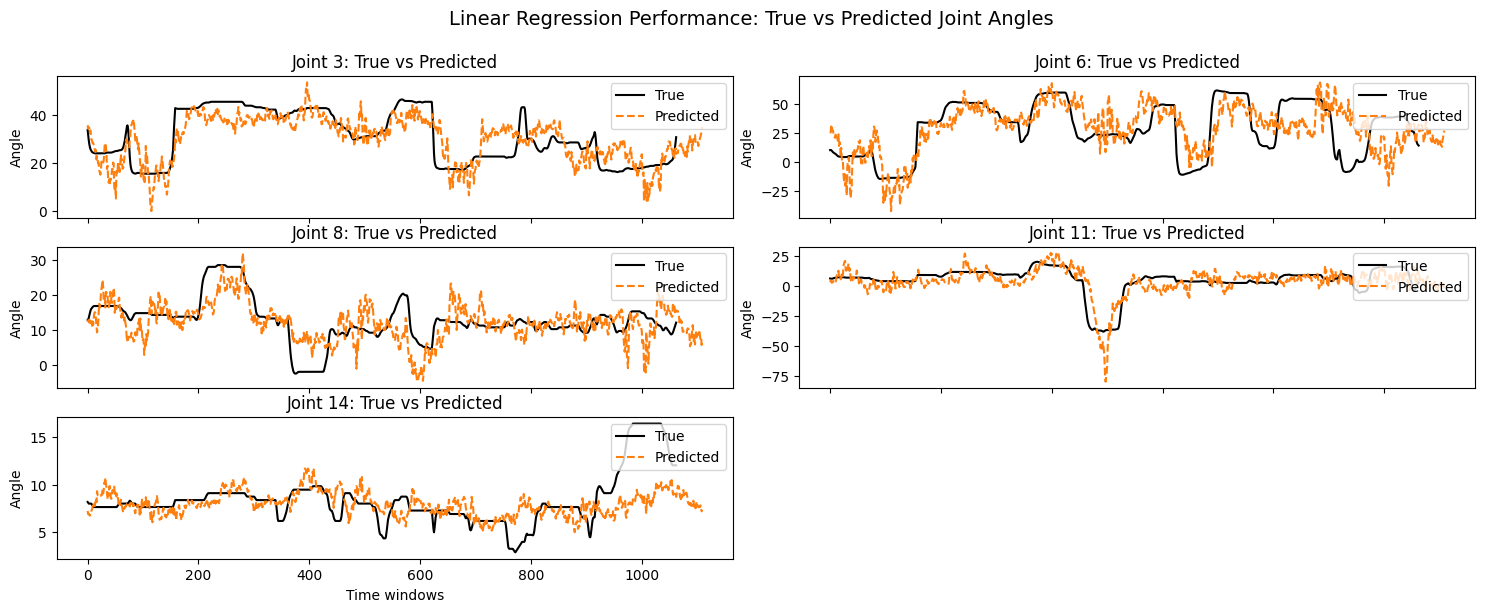

In [29]:
plt.close("all")

joint_ids = [3, 6, 8, 11, 14]
n_joints = len(joint_ids)

fig, axes = plt.subplots(3, 2, figsize=(15, 6), sharex=True)
fig.suptitle("Linear Regression Performance: True vs Predicted Joint Angles", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])


axes = axes.flatten()

for j, joint in enumerate(joint_ids):
    axes[j].plot(Labels_test_mean[:, j], label="True", color="black")
    axes[j].plot(y_pred_linear[:, j], linestyle="--", label="Predicted", color="tab:orange")
    axes[j].set_title(f"Joint {joint}: True vs Predicted")
    axes[j].set_ylabel("Angle")
    axes[j].legend(loc="upper right")
    axes[j].grid(False)

# Turn off the last empty subplot
axes[-1].axis('off')

axes[-2].set_xlabel("Time windows")  # Set x-label on the last real plot
plt.show()


### Metric for Linear Regression: testing on split with and without rest on val set
With the validation split we are comparing the loss to conclude whether we include the rests in the splits or not- this was done using the two different split variations above.

In [31]:

# Mean Absolute Error y_pred_linear vs Labels_test_mean
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Labels_val_mean, y_pred_linear)
print("Mean Absolute Error:", mae)

#Root Mean Square Error    
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Labels_val_mean, y_pred_linear))
print("Root Mean Square Error:", rmse)

Mean Absolute Error: 5.802347264682564
Root Mean Square Error: 8.549063073702705


Reporting the MSE on the test set

In [32]:
y_pred_linear = linear_regressor.predict(EMG_test_extracted_features)
# Mean Absolute Error y_pred_linear vs Labels_test_mean
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Labels_test_mean, y_pred_linear)
print("Mean Absolute Error:", mae)

#Root Mean Square Error    
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Labels_test_mean, y_pred_linear))
print("Root Mean Square Error:", rmse)

Mean Absolute Error: 5.934601858018145
Root Mean Square Error: 8.856860687422369
